In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
import seaborn as sns
sns.set() 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn.utils.extmath import softmax
from catboost import CatBoostClassifier

train = pd.read_csv('train.csv')

# Разведочный (исследовательский) анализ <a class="anchor" id="section-two-eda"></a>

## Исследуем обучающий набор (train) <a id="section-two-train-df-analysis"></a>

In [65]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [66]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [67]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [68]:
train.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


* Видно, что повторяются каюты. Самый большой порядок дубликата - 8. Значит в одной каюте живут до 8 человек.
* Самым популярным пунктом назначения является TRAPPIST-1e. (5915 чел)
* Больше всего человек летит с планеты Земля. (4602 чел)

## Проведем отчистку данных <a id="section-two-test-df-analysis"></a>
Дропнем колонку с **именем** и **id** пассажиров, это не будет влиять на их выживаемость

In [69]:
train = train.drop(['Name', 'PassengerId'], axis=1)

## Заполним пропуски <a id="section-two-test-df-analysis"></a>

In [70]:
train.isnull().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

Видим, что есть пропуски данных по 11 переменным

### Начнем с HomePLanet. Заполним пропуски самым частоным значением.

In [71]:
train.HomePlanet.value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

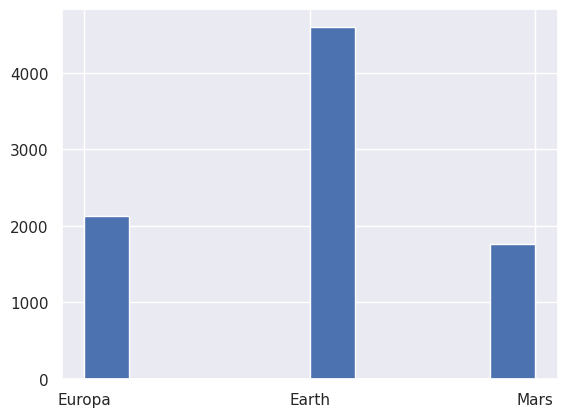

In [72]:
col = 'HomePlanet'
train[col].hist()
train[col].fillna('Earth', inplace=True)

Конвертируем категориальное значение в численное представление.

In [73]:
col = 'HomePlanet'
train[col] = train[col].map({"Earth": 1, "Europa": 2, "Mars": 3})
    
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,2,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,1,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,2,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,2,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,1,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


### Далее рассмотрим CryoSleep. Заполним пропуски самым частотным значением.

In [74]:
train.CryoSleep.value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [75]:
col = 'CryoSleep'
train[col].fillna(False, inplace=True)

### Далее рассмотрим Cabin.
Разделим данный столбец на три столбца - **deck/num/side**, которые в дальнейшем могут быть информативны.

При этом значение может иметь то, со сколькими людьми в одной кабине путешествует пассажир.
Поэтому созданим новый признак - **NumCabinMates**, который будет показывать со сколькими людьми в одной кабине путешествует пассажир. 
Можно предположить, что он характеризует количество родственников пассажира на корабле.


In [76]:
train.Cabin.value_counts()

Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64

In [77]:
relatives_mas = train.Cabin.unique()
relatives_mapping = {}
for el in relatives_mas:
    relatives_mapping[el] = len(train[train['Cabin']==el])

train['NumCabinMates'] = train['Cabin'].copy() 
train['NumCabinMates'] = train['NumCabinMates'].map(relatives_mapping)

train[['Deck', 'NumCabin', 'Side']] = train['Cabin'].str.split('/', expand=True)
train = train.drop('Cabin', axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   int64  
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8511 non-null   object 
 3   Age            8514 non-null   float64
 4   VIP            8490 non-null   object 
 5   RoomService    8512 non-null   float64
 6   FoodCourt      8510 non-null   float64
 7   ShoppingMall   8485 non-null   float64
 8   Spa            8510 non-null   float64
 9   VRDeck         8505 non-null   float64
 10  Transported    8693 non-null   bool   
 11  NumCabinMates  8693 non-null   int64  
 12  Deck           8494 non-null   object 
 13  NumCabin       8494 non-null   object 
 14  Side           8494 non-null   object 
dtypes: bool(2), float64(6), int64(2), object(5)
memory usage: 900.0+ KB


In [78]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,B,0,P
1,1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,F,0,S
2,2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,A,0,S
3,2,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,A,0,S
4,1,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,F,1,S


#### Восстановим пропуски и переведем из категориального вида в численное представление только что созданные столбцы

In [79]:
train.Deck.value_counts()

Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

<Axes: >

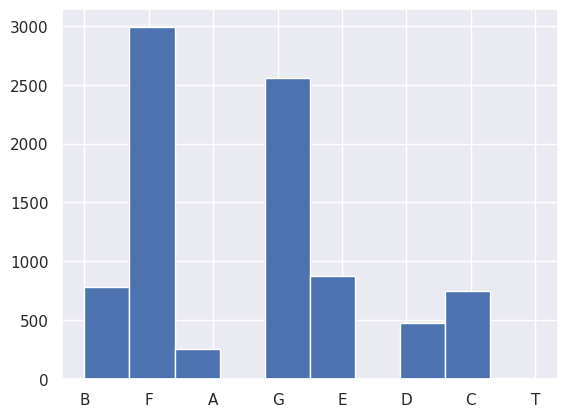

In [80]:
train['Deck'].fillna('F', inplace=True)
train['Deck'].hist()


In [81]:
col = 'Deck'
train[col] = train[col].map({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8})
    
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,P
1,1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,S
2,2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,S
3,2,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,S
4,1,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,S


<Axes: >

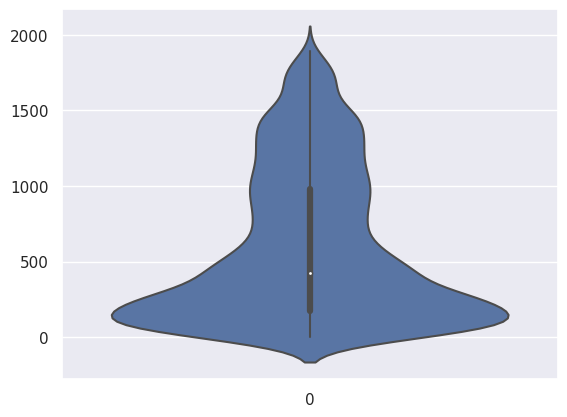

In [82]:
train['NumCabin'] = train['NumCabin'].fillna(train['NumCabin'].median())
sns.violinplot(train['NumCabin'])

In [83]:
train.Side.value_counts()

Side
S    4288
P    4206
Name: count, dtype: int64

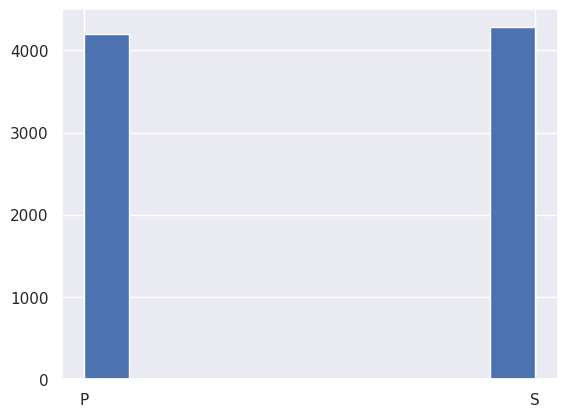

In [84]:
train['Side'].hist()
train['Side'].fillna('S', inplace=True)

In [85]:
col = 'Side'
train[col] = train[col].map({"S": 1, "P": 2})
    
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,2
1,1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,1
2,2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,1
3,2,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,1
4,1,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,1


### Далее рассмотрим Destination. Заполним пропуски самым частоным значением.

In [86]:
train.Destination.value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

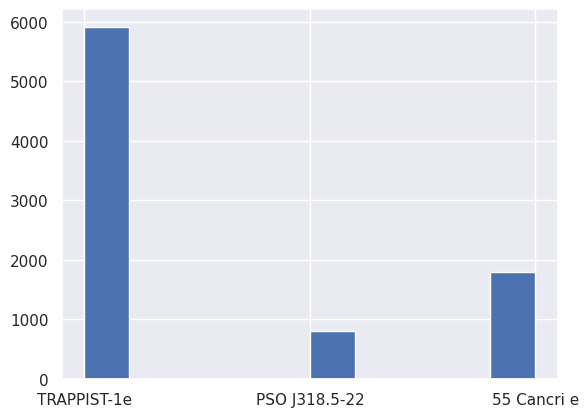

In [87]:
col = 'Destination'
train[col].hist()
train[col].fillna('TRAPPIST-1e', inplace=True)

Конвертируем категориальное значение в численное представление.

In [88]:
col = 'Destination'
dest_mapping = {"TRAPPIST-1e": 1, "55 Cancri e": 2, "PSO J318.5-22": 3}
train[col] = train[col].map(dest_mapping)
    
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,1,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,2
1,1,False,1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,1
2,2,False,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,1
3,2,False,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,1
4,1,False,1,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,1


### Далее рассмотрим Age. Заполним пропуски медианой.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


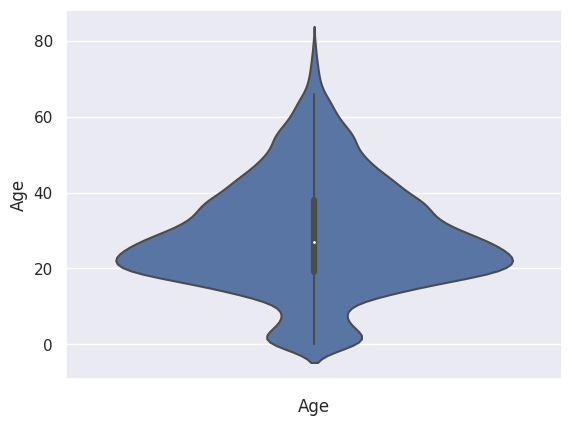

In [89]:
col = 'Age'
data = train[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим VIP. Заполним пропуски самым частотным значением.

In [90]:
train.VIP.value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

In [91]:
col = 'VIP'
train[col].fillna(False, inplace=True)

### Далее рассмотрим RoomService. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


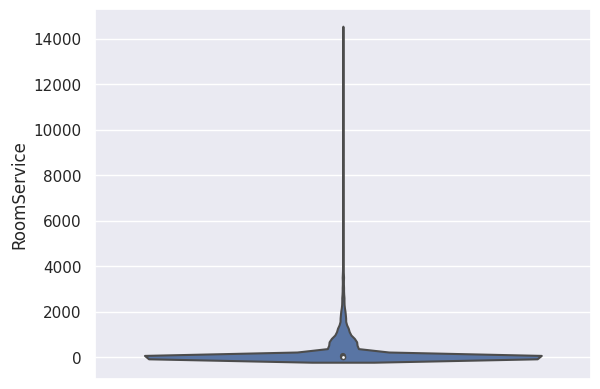

In [92]:
col = 'RoomService'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим FoodCourt. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


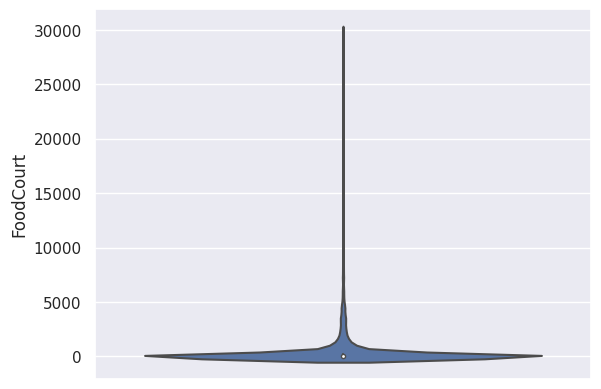

In [93]:
col = 'FoodCourt'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим ShoppingMall. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


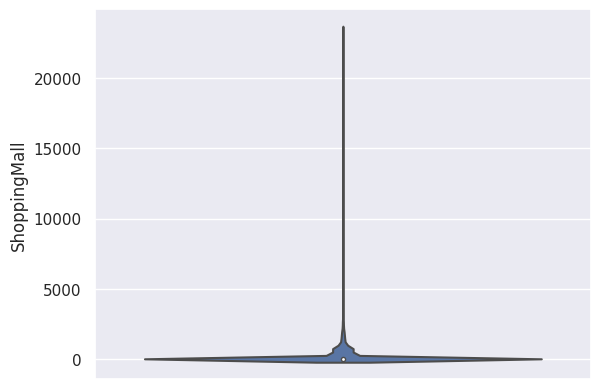

In [94]:
col = 'ShoppingMall'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим Spa. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


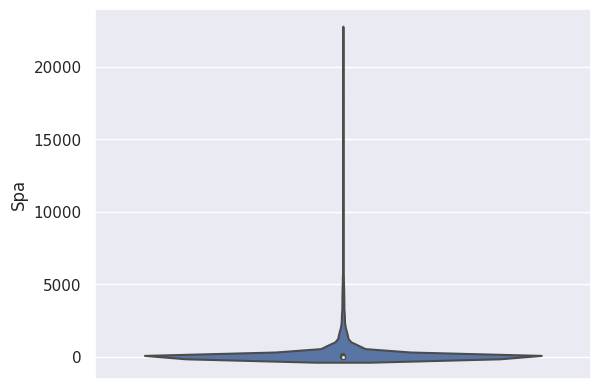

In [95]:
col = 'Spa'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Далее рассмотрим VRDeck. Заполним пропуски на медиану.

/home/neechan/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


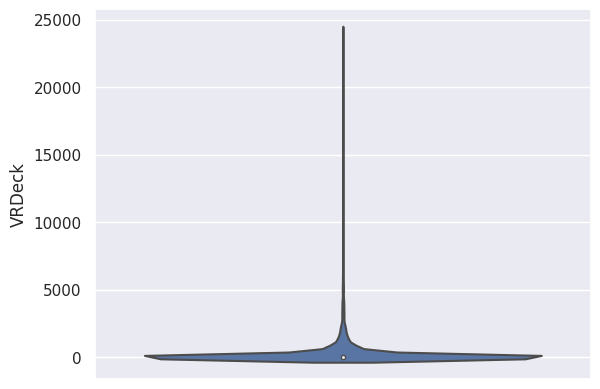

In [96]:
col = 'VRDeck'

data = train[col]
sns.violinplot(y=data)
plt.show()

train[col].fillna(train[col].median(), inplace=True)

### Проверим, что все пропуски заполнены

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     8693 non-null   int64  
 1   CryoSleep      8693 non-null   bool   
 2   Destination    8693 non-null   int64  
 3   Age            8693 non-null   float64
 4   VIP            8693 non-null   bool   
 5   RoomService    8693 non-null   float64
 6   FoodCourt      8693 non-null   float64
 7   ShoppingMall   8693 non-null   float64
 8   Spa            8693 non-null   float64
 9   VRDeck         8693 non-null   float64
 10  Transported    8693 non-null   bool   
 11  NumCabinMates  8693 non-null   int64  
 12  Deck           8693 non-null   int64  
 13  NumCabin       8693 non-null   object 
 14  Side           8693 non-null   int64  
dtypes: bool(3), float64(6), int64(5), object(1)
memory usage: 840.6+ KB


In [98]:
train.to_csv("prepared.csv") 
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,NumCabinMates,Deck,NumCabin,Side
0,2,False,1,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,2,0,2
1,1,False,1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,1,6,0,1
2,2,False,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,2,1,0,1
3,2,False,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,2,1,0,1
4,1,False,1,16.0,False,303.0,70.0,151.0,565.0,2.0,True,1,6,1,1
